In [1]:
import gurobipy as gp
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, PercentFormatter
import numpy as np
import pandas as pd
import re
import os
import shutil

In [108]:
# get input paths
test_set = "miplib_2017_5000"
instance_fldr = os.path.join("instances", test_set)
test_set_fldr = os.path.join("test_sets", test_set)
results_fldr = os.path.join("results", test_set)
out_fldr = os.path.join("outputs", test_set)

# set filters
degrees = [-1, 1]
term_list = [4, 16, 64]
filter_cbc = False
max_base_std = 1e10
min_termination_time = 10
short, medium, long = 60, 600, 3600
remove_status_changes = False
win_threshold = .1

# set up some mappings
cat_map_new_lines = {
    "None": "Default",
    "Farkas": "Param Disj,\nParam Cuts",
    "Old": "Param Disj,\nCalc Cuts",
    "New": "Calc Disj,\nCalc Cuts"
}
cat_map = {
    "None": "Default",
    "Farkas": "Param Disj, Param Cuts",
    "Old": "Param Disj, Calc Cuts",
    "New": "Calc Disj, Calc Cuts"
}
perturbation_map = {
    "matrix": "Coefficient Matrix",
    "rhs": "Right Hand Side",
    "bounds": "Variable Bounds",
    "objective": "Objective"
}
label = {
    "postRootTime": "Time after Processing Root nodes",
    "rootDualBoundTimeSansVpc": "Root Processing Time (Minus VPC Generation)",
    "terminationTimeSansVpc": "Time (Minus VPC Generation)",
    "terminationTime": "Time",
    "nodes": "Nodes Processed",
    "iterations": "LP iterations",
}
unit = {
    "postRootTime": "(seconds)",
    "rootDualBoundTimeSansVpc": "(seconds)",
    "terminationTimeSansVpc": "(seconds)",
    "terminationTime": "(seconds)",
    "nodes": "(1000 nodes)",
    "iterations": "(1000 iterations)",
}
limits = {
    "postRootTime": 7200,
    "terminationTimeSansVpc": 7200,
    "terminationTime": 7200,
    "rootDualBoundTimeSansVpc": 5,
    "nodes": 10000,
    "iterations": 37500
}
bracket_bounds = {
    "short": (min_termination_time, short),
    "medium": (short, medium),
    "long": (medium, long)
}
param_map = {
    "degree": "Degree of Perturbation",
    "terms": "Number of Disjunctive Terms",
}

In [3]:
# matplotlib settings
plt.rc('text', usetex=True)  # use latex fonts
plt.rcParams['font.size'] = 18
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 14

## Check run failures

In [4]:
# check if each folder in test_set_fldr has a corresponding .mps file in instance_fldr
# for instance in os.listdir(test_set_fldr):
#     if not os.path.isdir(os.path.join(test_set_fldr, instance)):
#         continue
#     if not os.path.exists(os.path.join(instance_fldr, f"{instance}.mps")):
#         # remove the folder if the instance is missing
#         # shutil.rmtree(os.path.join(test_set_fldr, instance))
#         print(f"Removed {instance} from test set")

In [5]:
# running list of strings contained by different error codes
# last two are catchalls
err = {
    "walltime": [],
    "bad_alloc": [],
    "out of memory": [],
    "takeoffcuts": [],
    "solver is dual infeasible": [],
    "solver must be optimal": [],
    "segmentation fault": [],
    "no vpcs were made from a new disjunction": [],
    "must have primalbound >= root lp objective": [],
    "objective at parent nodes": [],
    "failed to optimize mip": [],
    "disjunction does not represent a full binary tree": [],
    "solver not proven optimal for nodes": [],
    "unable to open": [],
    "license": [],
    "dot product with obj differs from solver": [],
    "gurobi: error during callback: addCut": [],
    "cglvpc::setupconstraints: objective at disjunctive term": [],
    "unable to read file": [],
    "stats.id == stats_vec": [],
    "size of our disjunction is not what we expected it to be": [],
}

# read in cbc acceptable instances from cbc.txt
with open("cbc.txt", "r") as f:
    cbc_instances = f.read().split("\n")

# runs that errored out with new error code
other = []

# runs that had no errors
empty = []

# runs that only had warnings
warn_strs = ["warning", "prlp is primal infeasible", "farkas", "x:", "x[", "b:",
             "b[", "v:", "v[", "cut:", "A_i . x", "dot product with obj differs from solver"]
warning = []

# series that didn't run
no_go = []

# track sizes of instances
rows, cols, density = {}, {}, {}

# map the names
names = {}

# counts
count_series = 0
count_instances = 0
number_instances = {}

# iterate over all expected runs
for instance in os.listdir(test_set_fldr):
    if not os.path.isdir(os.path.join(test_set_fldr, instance)):
        continue
    # only look at cbc instances if we ran with cbc
    if instance not in cbc_instances and "gurobi" not in test_set and filter_cbc:
        continue
        
    # get the number of rows and columns in the instance
    mdl = gp.read(os.path.join(instance_fldr, f"{instance}.mps"))
    rows[instance] = mdl.NumConstrs
    cols[instance] = mdl.NumVars
    density[instance] = mdl.NumNZs / (mdl.NumConstrs * mdl.NumVars)
        
    for perturbation in os.listdir(os.path.join(test_set_fldr, instance)):
        if not os.path.isdir(os.path.join(test_set_fldr, instance, perturbation)):
            continue
        # only look at perturbations that were run
        p, d = perturbation.split("_")
        if int(d) not in degrees:
            continue
        for terms in term_list:
            for generator in ["None", "New", "Old", "Farkas"]:

                # set variables for this iterations
                count_series += 1
                stem = f"{instance}_{perturbation}_{terms}_{generator}"
                file_pth = os.path.join(results_fldr, f"{stem}.err")
                series_fldr = os.path.join(test_set_fldr, instance, perturbation)
                current_count = len([f for f in os.listdir(series_fldr) if f.endswith(".mps")])
                count_instances += current_count
                names[stem] = instance
                number_instances[stem] = {
                    "expected": current_count,
                    "recorded": 0,
                    "generator": generator,
                    "error": "N/A"
                }

                # check if the series wasn't run
                if not os.path.exists(file_pth):
                    number_instances[stem]["error"] = "no go"
                    no_go.append(stem)
                
                # check if the series ran with no errors or warnings
                elif os.path.getsize(file_pth) == 0:
                    number_instances[stem]["error"] = "empty"
                    empty.append(stem)
                
                # track which error codes were thrown
                else:
                    # read the file
                    with open(file_pth, "r") as f:
                        text = f.read().lower()
                    
                    # assign the error file to the appropriate list
                    found_code = False
                    for code in err:
                        if code in text:
                            if code == "dot product with obj differs from solver":
                                pattern = r"obj viol from solver: (\d+\.\d+)\. calculated: (\d+\.\d+)"
                                s, c = re.findall(pattern, text)[-1]
                                # if we didn't terminate, this isn't an error, so keep going
                                if abs(float(s) - float(c)) < 1e-3:
                                    continue
                            err[code].append(stem)
                            found_code = True
                            number_instances[stem]["error"] = code
                            break
                    if not found_code:
                        if all(not line or any(w in line for w in warn_strs) for line in text.splitlines()):
                            warning.append(stem)
                            number_instances[stem]["error"] = "warning"
                        else:
                            other.append(stem)
                            number_instances[stem]["error"] = "other"

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Read MPS format model from file instances/miplib_2017_5000/bienst2.mps
Reading time = 0.00 seconds
bienst2: 576 rows, 505 columns, 2184 nonzeros
Read MPS format model from file instances/miplib_2017_5000/set3-15.mps
Reading time = 0.00 seconds
set3-15: 3747 rows, 4019 columns, 13747 nonzeros
Read MPS format model from file instances/miplib_2017_5000/f2gap801600.mps
Reading time = 0.00 seconds
f2gap801600: 80 rows, 1600 columns, 3200 nonzeros
Read MPS format model from file instances/miplib_2017_5000/stein15inf.mps
Reading time = 0.00 seconds
stein15inf: 37 rows, 15 columns, 135 nonzeros
Read MPS format model from file instances/miplib_2017_5000/neos-3610173-itata.mps
Reading time = 0.00 seconds
neos-3610173-itata: 747 rows, 844 columns, 2130 nonzeros
Read MPS format model from file instances/miplib_2017_5000/10teams.mps
Reading time = 0.00 seconds
10TEAMS: 230 rows, 2025 columns, 12150 nonzeros
R

In [6]:
# check which series didn't run
print(no_go)

['mine-90-10_matrix_-1_4_None', 'mine-90-10_matrix_-1_4_New', 'mine-90-10_matrix_-1_4_Old', 'mine-90-10_matrix_-1_4_Farkas', 'mine-90-10_matrix_-1_16_None', 'mine-90-10_matrix_-1_16_New', 'mine-90-10_matrix_-1_16_Old', 'mine-90-10_matrix_-1_16_Farkas', 'mine-90-10_matrix_-1_64_None', 'mine-90-10_matrix_-1_64_New', 'mine-90-10_matrix_-1_64_Old', 'mine-90-10_matrix_-1_64_Farkas', 'mine-90-10_objective_-1_16_Farkas', 'mine-90-10_objective_-1_64_None', 'mine-90-10_objective_-1_64_New', 'mine-90-10_objective_-1_64_Old', 'mine-90-10_objective_-1_64_Farkas', 'a2c1s1_rhs_1_4_None', 'a2c1s1_rhs_1_4_New', 'a2c1s1_rhs_1_4_Old', 'a2c1s1_rhs_1_4_Farkas', 'a2c1s1_rhs_1_16_None', 'a2c1s1_rhs_1_16_New', 'a2c1s1_rhs_1_16_Old', 'a2c1s1_rhs_1_16_Farkas', 'a2c1s1_rhs_1_64_None', 'a2c1s1_rhs_1_64_New', 'a2c1s1_rhs_1_64_Old', 'a2c1s1_rhs_1_64_Farkas', 'a2c1s1_objective_1_4_None', 'a2c1s1_objective_1_4_New', 'a2c1s1_objective_1_4_Old', 'a2c1s1_objective_1_4_Farkas', 'a2c1s1_objective_1_16_None', 'a2c1s1_obje

In [7]:
# get the proportion of series that at least got started
1 - (len(no_go) / count_series)

0.9793404094010614

In [8]:
# out of time - got hung up in code somewhere - ok
print(err["walltime"])
len(err["walltime"]) / count_series

['neos-1445738_bound_1_4_New', 'neos-1445738_bound_1_16_New']


0.00012635835228708617

In [9]:
# out of memory - memory is maxed already - this is what it is
# todo: figure out where we ran short on memory so we can explain why we dropped them
print(err["bad_alloc"] + err["out of memory"])
len(err["bad_alloc"] + err["out of memory"]) / count_series

['10teams_objective_1_16_New', '10teams_objective_1_16_Old', '10teams_objective_1_16_Farkas', '10teams_objective_1_64_New', '10teams_objective_1_64_Old', '10teams_objective_1_64_Farkas', '10teams_matrix_1_16_Old', '10teams_matrix_1_16_Farkas', '10teams_matrix_1_64_Old', '10teams_matrix_1_64_Farkas', '10teams_objective_-1_16_New', '10teams_objective_-1_16_Old', '10teams_objective_-1_16_Farkas', '10teams_objective_-1_64_New', '10teams_objective_-1_64_Old', '10teams_objective_-1_64_Farkas', '10teams_bound_1_16_New', '10teams_bound_1_16_Old', '10teams_bound_1_16_Farkas', '10teams_bound_1_64_New', '10teams_bound_1_64_Old', '10teams_bound_1_64_Farkas', 'ci-s4_objective_1_64_New', 'ci-s4_objective_1_64_Old', 'ci-s4_objective_1_64_Farkas', 'ci-s4_objective_-1_64_New', 'ci-s4_objective_-1_64_Old', 'ci-s4_objective_-1_64_Farkas', 'neos-585192_objective_1_64_Old', 'neos-585192_objective_1_64_Farkas', 'neos-585192_objective_-1_64_New', 'neos-585192_objective_-1_64_Old', 'neos-585192_objective_-1_6

0.05060652009097801

In [10]:
# rerun this if want to give more memory to some instances
# bad_alloc_names = set(n.split("_")[0] for n in err["bad_alloc"])
# mem = pd.read_csv("more_memory.csv", index_col=0)
# mem["reason"] = "hard solve" 
# 
# for n in bad_alloc_names:
#     if f"{n}.mps" not in mem.index:
#         new_row = pd.DataFrame([{'file_name': f"{n}.mps", 'memory': 16.0, 'reason': 'big disjunction'}]).set_index('file_name')
#         mem = pd.concat([mem, new_row])
#     else:
#         mem.loc[f'{n}.mps', 'memory'] = 16.0
# 
# mem.to_csv("more_memory.csv")

In [11]:
# this is an issue with John's bookkeeping - not much we can do here
print(err["takeoffcuts"])
len(err["takeoffcuts"]) / count_series

[]


0.0

In [12]:
print(err["solver is dual infeasible"])
len(err["solver is dual infeasible"]) / count_series

[]


0.0

In [13]:
# these are usually issues with CLP finding optimality - not much we can do here
print(err["solver must be optimal"])
len(err["solver must be optimal"]) / count_series

[]


0.0

In [14]:
print(err["segmentation fault"])
len(err["segmentation fault"]) / count_series

[]


0.0

In [15]:
seg_err = {
    "Bad image at line": [],
}

seg_other = []

for stem in err["segmentation fault"]:
    file_pth = os.path.join(results_fldr, f"{stem}.out")

    with open(file_pth, "r") as f:
        text = f.read()
    
    # assign the error file to the appropriate list
    found_code = False
    for code in seg_err:
        if code in text:
            seg_err[code].append(stem)
            found_code = True
            break
    if not found_code:
        seg_other.append(stem)

In [16]:
print(seg_err["Bad image at line"])
len(seg_err["Bad image at line"]) / len(err["segmentation fault"]) if err["segmentation fault"] else 0

[]


0

In [17]:
print(seg_other)
len(seg_other)/len(err["segmentation fault"]) if err["segmentation fault"] else 0

[]


0

In [18]:
# get breakdown of why vpc generation failed - mostly from lack of provisioning
for code, exps in seg_err.items():
    print(f"{code}: {len(exps) / len(err['segmentation fault']) if err['segmentation fault'] else 0}")

print(f"other: {len(seg_other) / len(err['segmentation fault']) if err['segmentation fault'] else 0}")

Bad image at line: 0
other: 0


In [19]:
# todo: check aleks' removals and drop those below for similar reasons
# todo: check size of disjunctions and decide what to do with those that are too big
# these should all be from the problem being too big and hitting the time limit or integer solutions
print(err["no vpcs were made from a new disjunction"])
missing_4_term = [n for n in err["no vpcs were made from a new disjunction"] if "_4_" in n]
missing_64_term = [n for n in err["no vpcs were made from a new disjunction"] if "_64_" in n]
missing_16_term = [n for n in err["no vpcs were made from a new disjunction"] if "_16_" in n]
print(f'4 term: {len(missing_4_term) / count_series}')
print(f'64 term: {len(missing_64_term) / count_series}')
print(f'16 term: {len(missing_16_term) / count_series}')

['bienst2_rhs_1_64_New', 'bienst2_rhs_1_64_Old', 'bienst2_rhs_1_64_Farkas', 'bienst2_objective_1_64_New', 'bienst2_objective_1_64_Old', 'bienst2_objective_1_64_Farkas', 'bienst2_matrix_-1_64_New', 'bienst2_matrix_-1_64_Old', 'bienst2_matrix_-1_64_Farkas', 'bienst2_objective_-1_64_New', 'bienst2_objective_-1_64_Old', 'bienst2_objective_-1_64_Farkas', 'neos-555343_rhs_1_4_New', 'neos-555343_rhs_1_4_Old', 'neos-555343_rhs_1_4_Farkas', 'neos-555343_rhs_1_16_New', 'neos-555343_rhs_1_16_Old', 'neos-555343_rhs_1_16_Farkas', 'neos-555343_rhs_1_64_New', 'neos-555343_rhs_1_64_Old', 'neos-555343_rhs_1_64_Farkas', 'neos-555343_objective_1_4_New', 'neos-555343_objective_1_4_Old', 'neos-555343_objective_1_4_Farkas', 'neos-555343_objective_1_16_New', 'neos-555343_objective_1_16_Old', 'neos-555343_objective_1_16_Farkas', 'neos-555343_objective_1_64_New', 'neos-555343_objective_1_64_Old', 'neos-555343_objective_1_64_Farkas', 'neos-555343_matrix_1_4_New', 'neos-555343_matrix_1_4_Old', 'neos-555343_matri

In [20]:
vpc_err = {
    "CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT": [],
    "CglVPC: Finishing with exit reason: TIME_LIMIT": [],
    "CglVPC: Finishing with exit reason: NO_CUTS_LIKELY": [],
    "CglVPC: Finishing with exit reason: PRLP_INFEASIBLE": [],
    "CglVPC: Finishing with exit reason: SUCCESS": [],
    "CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND": [],
    "CglVPC: Finishing with exit reason: FAIL_LIMIT": [],
    "CglVPC: Finishing with exit reason: NO_DISJUNCTION": [],
}

vpc_other = []

for stem in err["no vpcs were made from a new disjunction"]:
    file_pth = os.path.join(results_fldr, f"{stem}.out")

    with open(file_pth, "r") as f:
        text = f.read()
    
    # assign the error file to the appropriate list
    found_code = False
    for code in vpc_err:
        if code in text:
            vpc_err[code].append(stem)
            found_code = True
            break
    if not found_code:
        vpc_other.append(stem)

In [21]:
print(vpc_err["CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['bienst2_rhs_1_64_New', 'bienst2_rhs_1_64_Old', 'bienst2_rhs_1_64_Farkas', 'bienst2_objective_1_64_New', 'bienst2_objective_1_64_Old', 'bienst2_objective_1_64_Farkas', 'bienst2_matrix_-1_64_New', 'bienst2_matrix_-1_64_Old', 'bienst2_matrix_-1_64_Farkas', 'bienst2_objective_-1_64_New', 'bienst2_objective_-1_64_Old', 'bienst2_objective_-1_64_Farkas', 'lrn_objective_1_16_New', 'lrn_objective_1_16_Old', 'lrn_objective_1_16_Farkas', 'lrn_objective_1_64_New', 'lrn_objective_1_64_Old', 'lrn_objective_1_64_Farkas', 'lrn_objective_-1_16_New', 'lrn_objective_-1_16_Old', 'lrn_objective_-1_16_Farkas', 'lrn_objective_-1_64_New', 'lrn_objective_-1_64_Old', 'lrn_objective_-1_64_Farkas', 'lrn_bound_1_16_New', 'lrn_bound_1_16_Old', 'lrn_bound_1_16_Farkas', 'lrn_bound_1_64_New', 'lrn_bound_1_64_Old', 'lrn_bound_1_64_Farkas', 'neos-503737_objective_1_16_New', 'neos-503737_objective_1_16_Old', 'neos-503737_objective_1_16_Farkas', 'neos-503737_objective_1_64_New', 'neos-503737_objective_1_64_Old', 'neos-5

0.22032726434662364

In [22]:
print(vpc_err["CglVPC: Finishing with exit reason: TIME_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: TIME_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['ns1208400_rhs_1_16_New', 'ns1208400_rhs_1_16_Old', 'ns1208400_rhs_1_16_Farkas', 'ns1208400_rhs_1_64_New', 'ns1208400_rhs_1_64_Old', 'ns1208400_rhs_1_64_Farkas', 'ns1208400_objective_1_16_New', 'ns1208400_objective_1_16_Old', 'ns1208400_objective_1_16_Farkas', 'ns1208400_objective_1_64_New', 'ns1208400_objective_1_64_Old', 'ns1208400_objective_1_64_Farkas', 'ns1208400_matrix_1_16_New', 'ns1208400_matrix_1_16_Old', 'ns1208400_matrix_1_16_Farkas', 'ns1208400_matrix_1_64_New', 'ns1208400_matrix_1_64_Old', 'ns1208400_matrix_1_64_Farkas', 'ns1208400_matrix_-1_16_New', 'ns1208400_matrix_-1_16_Old', 'ns1208400_matrix_-1_16_Farkas', 'ns1208400_matrix_-1_64_New', 'ns1208400_matrix_-1_64_Old', 'ns1208400_matrix_-1_64_Farkas', 'ns1208400_objective_-1_16_New', 'ns1208400_objective_-1_16_Old', 'ns1208400_objective_-1_16_Farkas', 'ns1208400_objective_-1_64_New', 'ns1208400_objective_-1_64_Old', 'ns1208400_objective_-1_64_Farkas', 'ns1208400_bound_1_16_New', 'ns1208400_bound_1_16_Old', 'ns1208400_bo

0.04378889144964278

In [23]:
print(vpc_err["CglVPC: Finishing with exit reason: NO_CUTS_LIKELY"])
len(vpc_err["CglVPC: Finishing with exit reason: NO_CUTS_LIKELY"]) / len(err["no vpcs were made from a new disjunction"])

['neos-555343_rhs_1_4_New', 'neos-555343_rhs_1_4_Old', 'neos-555343_rhs_1_4_Farkas', 'neos-555343_rhs_1_16_New', 'neos-555343_rhs_1_16_Old', 'neos-555343_rhs_1_16_Farkas', 'neos-555343_objective_1_4_New', 'neos-555343_objective_1_4_Old', 'neos-555343_objective_1_4_Farkas', 'neos-555343_objective_1_16_New', 'neos-555343_objective_1_16_Old', 'neos-555343_objective_1_16_Farkas', 'neos-555343_matrix_1_4_New', 'neos-555343_matrix_1_4_Old', 'neos-555343_matrix_1_4_Farkas', 'neos-555343_matrix_1_16_New', 'neos-555343_matrix_1_16_Old', 'neos-555343_matrix_1_16_Farkas', 'neos-555343_bound_1_4_New', 'neos-555343_bound_1_4_Old', 'neos-555343_bound_1_4_Farkas', 'neos-555343_bound_1_16_New', 'neos-555343_bound_1_16_Old', 'neos-555343_bound_1_16_Farkas', 'pigeon-20_rhs_1_4_New', 'pigeon-20_rhs_1_4_Old', 'pigeon-20_rhs_1_4_Farkas', 'pigeon-20_objective_1_4_New', 'pigeon-20_objective_1_4_Old', 'pigeon-20_objective_1_4_Farkas', 'pigeon-20_matrix_1_4_New', 'pigeon-20_matrix_1_4_Old', 'pigeon-20_matrix_1

0.46877160636091264

In [24]:
print(vpc_err["CglVPC: Finishing with exit reason: PRLP_INFEASIBLE"])
len(vpc_err["CglVPC: Finishing with exit reason: PRLP_INFEASIBLE"]) / len(err["no vpcs were made from a new disjunction"])

['neos-555343_rhs_1_64_New', 'neos-555343_rhs_1_64_Old', 'neos-555343_rhs_1_64_Farkas', 'neos-555343_objective_1_64_New', 'neos-555343_objective_1_64_Old', 'neos-555343_objective_1_64_Farkas', 'neos-555343_matrix_1_64_New', 'neos-555343_matrix_1_64_Old', 'neos-555343_matrix_1_64_Farkas', 'neos-555343_bound_1_64_New', 'neos-555343_bound_1_64_Old', 'neos-555343_bound_1_64_Farkas', 'pigeon-20_rhs_1_64_New', 'pigeon-20_rhs_1_64_Old', 'pigeon-20_rhs_1_64_Farkas', 'pigeon-20_objective_1_64_New', 'pigeon-20_objective_1_64_Old', 'pigeon-20_objective_1_64_Farkas', 'pigeon-20_matrix_1_64_New', 'pigeon-20_matrix_1_64_Old', 'pigeon-20_matrix_1_64_Farkas', 'pigeon-20_rhs_-1_64_New', 'pigeon-20_rhs_-1_64_Old', 'pigeon-20_rhs_-1_64_Farkas', 'pigeon-20_bound_-1_64_New', 'pigeon-20_bound_-1_64_Old', 'pigeon-20_bound_-1_64_Farkas', 'pigeon-20_matrix_-1_64_New', 'pigeon-20_matrix_-1_64_Old', 'pigeon-20_matrix_-1_64_Farkas', 'pigeon-20_objective_-1_64_New', 'pigeon-20_objective_-1_64_Old', 'pigeon-20_obje

0.0884996542982254

In [25]:
print(vpc_err["CglVPC: Finishing with exit reason: SUCCESS"])
len(vpc_err["CglVPC: Finishing with exit reason: SUCCESS"]) / len(err["no vpcs were made from a new disjunction"])

['neos-1112787_rhs_1_4_New', 'neos-1112787_rhs_1_4_Old', 'neos-1112787_rhs_1_4_Farkas', 'neos-1112787_rhs_1_16_New', 'neos-1112787_rhs_1_16_Old', 'neos-1112787_rhs_1_16_Farkas', 'neos-1112787_objective_1_4_New', 'neos-1112787_objective_1_4_Old', 'neos-1112787_objective_1_4_Farkas', 'neos-1112787_objective_1_16_Old', 'neos-1112787_matrix_1_4_New', 'neos-1112787_matrix_1_4_Old', 'neos-1112787_matrix_1_4_Farkas', 'neos-1112787_matrix_1_16_New', 'neos-1112787_matrix_1_16_Old', 'neos-1112787_rhs_-1_4_New', 'neos-1112787_rhs_-1_4_Old', 'neos-1112787_rhs_-1_4_Farkas', 'neos-1112787_rhs_-1_16_New', 'neos-1112787_rhs_-1_16_Old', 'neos-1112787_matrix_-1_4_New', 'neos-1112787_matrix_-1_4_Old', 'neos-1112787_matrix_-1_4_Farkas', 'neos-1112787_matrix_-1_16_New', 'neos-1112787_matrix_-1_16_Farkas', 'neos-1112787_objective_-1_4_New', 'neos-1112787_objective_-1_4_Old', 'neos-1112787_objective_-1_4_Farkas', 'neos-1112787_objective_-1_16_New', 'neos-1112787_objective_-1_16_Old', 'neos-1112787_objective_

0.01866789582853192

In [26]:
print(vpc_err["CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND"])
len(vpc_err["CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND"]) / len(err["no vpcs were made from a new disjunction"])

['tanglegram6_objective_1_16_New', 'tanglegram6_objective_1_16_Old', 'tanglegram6_objective_1_16_Farkas', 'tanglegram6_objective_1_64_New', 'tanglegram6_objective_1_64_Old', 'tanglegram6_objective_1_64_Farkas', 'tanglegram6_matrix_1_16_New', 'tanglegram6_matrix_1_16_Old', 'tanglegram6_matrix_1_16_Farkas', 'tanglegram6_matrix_1_64_New', 'tanglegram6_matrix_1_64_Old', 'tanglegram6_matrix_1_64_Farkas', 'tanglegram6_objective_-1_16_New', 'tanglegram6_objective_-1_16_Old', 'tanglegram6_objective_-1_16_Farkas', 'tanglegram6_objective_-1_64_New', 'tanglegram6_objective_-1_64_Old', 'tanglegram6_objective_-1_64_Farkas', 'rentacar_objective_1_64_New', 'rentacar_objective_1_64_Old', 'rentacar_objective_1_64_Farkas', 'rentacar_matrix_-1_64_New', 'rentacar_matrix_-1_64_Old', 'rentacar_matrix_-1_64_Farkas', 'rentacar_objective_-1_64_New', 'rentacar_objective_-1_64_Old', 'rentacar_objective_-1_64_Farkas', 'neos-1425699_rhs_1_4_New', 'neos-1425699_rhs_1_4_Old', 'neos-1425699_rhs_1_4_Farkas', 'neos-142

0.07605439041253745

In [27]:
print(vpc_err["CglVPC: Finishing with exit reason: FAIL_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: FAIL_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['lrn_objective_1_4_New', 'lrn_objective_1_4_Old', 'lrn_objective_1_4_Farkas', 'lrn_objective_-1_4_Old', 'lrn_bound_1_4_New', 'lrn_bound_1_4_Farkas', 'neos-1112787_objective_1_16_New', 'neos-1112787_objective_1_16_Farkas', 'neos-1112787_matrix_1_16_Farkas', 'neos-1112787_matrix_-1_16_Old', 'neos-1112787_bound_1_16_Old', 'milo-v12-6-r2-40-1_objective_1_4_New', 'milo-v12-6-r2-40-1_objective_1_4_Old', 'milo-v12-6-r2-40-1_objective_1_4_Farkas', 'milo-v12-6-r2-40-1_objective_1_64_New', 'milo-v12-6-r2-40-1_objective_1_64_Old', 'milo-v12-6-r2-40-1_objective_1_64_Farkas', 'milo-v12-6-r2-40-1_objective_-1_4_New', 'milo-v12-6-r2-40-1_objective_-1_4_Old', 'milo-v12-6-r2-40-1_objective_-1_4_Farkas', 'milo-v12-6-r2-40-1_objective_-1_64_New', 'milo-v12-6-r2-40-1_objective_-1_64_Old', 'milo-v12-6-r2-40-1_objective_-1_64_Farkas', 'neos-1112782_rhs_1_64_New', 'neos-1112782_rhs_1_64_Farkas', 'neos-1112782_objective_1_64_New', 'neos-1112782_objective_1_64_Old', 'neos-1112782_matrix_1_64_Old', 'neos-11127

0.011292924637013136

In [28]:
print(vpc_err["CglVPC: Finishing with exit reason: NO_DISJUNCTION"])
len(vpc_err["CglVPC: Finishing with exit reason: NO_DISJUNCTION"]) / len(err["no vpcs were made from a new disjunction"])

['rentacar_objective_1_16_New', 'rentacar_objective_1_16_Old', 'rentacar_objective_1_16_Farkas', 'rentacar_matrix_-1_16_New', 'rentacar_matrix_-1_16_Old', 'rentacar_matrix_-1_16_Farkas', 'rentacar_objective_-1_16_New', 'rentacar_objective_-1_16_Old', 'rentacar_objective_-1_16_Farkas', 'supportcase26_rhs_1_16_New', 'supportcase26_rhs_1_16_Old', 'supportcase26_rhs_1_16_Farkas', 'supportcase26_rhs_1_64_New', 'supportcase26_rhs_1_64_Old', 'supportcase26_rhs_1_64_Farkas', 'supportcase26_objective_1_16_New', 'supportcase26_objective_1_16_Old', 'supportcase26_objective_1_16_Farkas', 'supportcase26_objective_1_64_New', 'supportcase26_objective_1_64_Old', 'supportcase26_objective_1_64_Farkas', 'supportcase26_rhs_-1_16_New', 'supportcase26_rhs_-1_16_Old', 'supportcase26_rhs_-1_16_Farkas', 'supportcase26_rhs_-1_64_New', 'supportcase26_rhs_-1_64_Old', 'supportcase26_rhs_-1_64_Farkas', 'supportcase26_matrix_-1_16_New', 'supportcase26_matrix_-1_16_Old', 'supportcase26_matrix_-1_16_Farkas', 'supportc

0.07259737266651302

In [29]:
vpc_other

[]

In [30]:
# get breakdown of why vpc generation failed - mostly from lack of provisioning/problem being too large
for code, exps in vpc_err.items():
    print(f"{code}: {len(exps) / len(err['no vpcs were made from a new disjunction'])}")

print(f"other: {len(vpc_other) / len(err['no vpcs were made from a new disjunction'])}")

CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT: 0.22032726434662364
CglVPC: Finishing with exit reason: TIME_LIMIT: 0.04378889144964278
CglVPC: Finishing with exit reason: NO_CUTS_LIKELY: 0.46877160636091264
CglVPC: Finishing with exit reason: PRLP_INFEASIBLE: 0.0884996542982254
CglVPC: Finishing with exit reason: SUCCESS: 0.01866789582853192
CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND: 0.07605439041253745
CglVPC: Finishing with exit reason: FAIL_LIMIT: 0.011292924637013136
CglVPC: Finishing with exit reason: NO_DISJUNCTION: 0.07259737266651302
other: 0.0


In [31]:
print(err["must have primalbound >= root lp objective"])
len(err["must have primalbound >= root lp objective"]) / count_series

['neos4_objective_1_4_None', 'neos4_objective_1_16_None', 'neos4_objective_1_64_None', 'supportcase25_bound_1_4_None', 'supportcase25_bound_1_4_New', 'supportcase25_bound_1_4_Old', 'supportcase25_bound_1_4_Farkas', 'supportcase25_bound_1_16_None', 'supportcase25_bound_1_16_New', 'supportcase25_bound_1_16_Old', 'supportcase25_bound_1_16_Farkas', 'supportcase25_bound_1_64_None']


0.000758150113722517

In [32]:
# LP relaxation objective is not going to match root nodes objective when warm starting 
print(err["objective at parent nodes"])
len(err["objective at parent nodes"]) / count_series

[]


0.0

In [33]:
# not enough tolerance added to bound (or we hit time limit) - element 2 from 5 and 4 from 4
print(err["failed to optimize mip"])
len(err["failed to optimize mip"]) / count_series

['f2gap40400_objective_1_4_Old', 'f2gap40400_objective_1_16_Old', 'f2gap40400_objective_1_64_Old']


0.00018953752843062926

In [34]:
# todo: figure out why
print(err["disjunction does not represent a full binary tree"])
len(err["disjunction does not represent a full binary tree"]) / count_series

[]


0.0

In [35]:
# again issue with not getting through vpc generation in time
# todo: handle this gracefully
print(err["solver not proven optimal for nodes"])
len(err["solver not proven optimal for nodes"]) / count_series

[]


0.0

In [36]:
print(err["unable to open"])
len(err["unable to open"]) / count_series

[]


0.0

In [37]:
print(err["license"])
len(err["license"]) / count_series

[]


0.0

In [38]:
print(warning)
len(warning) / count_series

['bienst2_rhs_1_4_New', 'bienst2_rhs_1_4_Old', 'bienst2_rhs_1_4_Farkas', 'bienst2_rhs_1_16_New', 'bienst2_rhs_1_16_Old', 'bienst2_objective_1_4_New', 'bienst2_objective_1_4_Farkas', 'bienst2_objective_1_16_Old', 'bienst2_matrix_-1_4_New', 'bienst2_matrix_-1_4_Old', 'bienst2_matrix_-1_16_New', 'bienst2_matrix_-1_16_Old', 'bienst2_objective_-1_4_Farkas', 'bienst2_objective_-1_16_New', 'bienst2_objective_-1_16_Old', 'f2gap801600_objective_1_4_Old', 'f2gap801600_objective_1_16_New', 'f2gap801600_objective_1_16_Old', 'f2gap801600_objective_1_16_Farkas', 'f2gap801600_objective_1_64_New', 'f2gap801600_rhs_-1_16_New', 'f2gap801600_rhs_-1_16_Old', 'f2gap801600_rhs_-1_16_Farkas', 'f2gap801600_objective_-1_16_New', 'f2gap801600_objective_-1_16_Old', 'f2gap801600_objective_-1_16_Farkas', 'f2gap801600_objective_-1_64_New', 'f2gap801600_objective_-1_64_Old', 'f2gap801600_bound_1_16_New', 'f2gap801600_bound_1_16_Old', 'f2gap801600_bound_1_16_Farkas', 'f2gap801600_bound_1_64_New', 'neos-3610173-itata_

0.0936947182208744

In [39]:
# errors unaccounted for
print(other)
len(other) / count_series

['neos-585192_objective_1_64_New', 'eil33-2_objective_1_4_New', 'neos-1445765_bound_1_4_New']


0.00018953752843062926

In [40]:
# proportion of series that were improperly provisioned
(len(err["bad_alloc"] + err["out of memory"] + err["walltime"])) / count_series

0.0507328784432651

In [41]:
# todo handle this
print(err["dot product with obj differs from solver"])
len(err["dot product with obj differs from solver"]) / count_series

['lrn_objective_-1_4_New', 'neos-3734794-moppy_matrix_-1_4_New', 'neos-3734794-moppy_matrix_-1_4_Old', 'neos-3734794-moppy_matrix_-1_16_New', 'neos-3734794-moppy_matrix_-1_16_Old', 'neos-3734794-moppy_matrix_-1_64_New', 'neos-3734794-moppy_matrix_-1_64_Old', 'neos-3592146-hawea_matrix_-1_4_New', 'neos-3592146-hawea_matrix_-1_16_New', 'neos-3592146-hawea_matrix_-1_64_New']


0.0006317917614354309

In [42]:
# changed code to ignore this error
print(err["gurobi: error during callback: addCut"])
len(err["gurobi: error during callback: addCut"]) / count_series

[]


0.0

In [43]:
# largely not replicating - only issue I could find was aleks missing updated objective from CLP when resolving to check this
print(err["cglvpc::setupconstraints: objective at disjunctive term"])
len(err["cglvpc::setupconstraints: objective at disjunctive term"]) / count_series

['aligninq_matrix_1_4_New', 'aligninq_matrix_1_16_New', '23588_matrix_1_64_New']


0.00018953752843062926

In [44]:
# not replicating - rerun
print(err["unable to read file"])
len(err["unable to read file"]) / count_series

[]


0.0

In [45]:
# not replicating - rerun
print(err["stats.id == stats_vec"])
len(err["stats.id == stats_vec"]) / count_series

[]


0.0

In [46]:
print(err["size of our disjunction is not what we expected it to be"])
len(err["size of our disjunction is not what we expected it to be"]) / count_series

[]


0.0

In [47]:
# get breakdown of errors
for code, exps in err.items():
    print(f"{code}: {len(exps) / count_series}")

print(f"other: {len(other) / count_series}")

print(f"warning: {len(warning) / count_series}")

print(f"no errors/warnings: {len(empty) / count_series}")

print(f"no go: {len(no_go) / count_series}")

walltime: 0.00012635835228708617
bad_alloc: 0.04814253222137983
out of memory: 0.0024639878695981803
takeoffcuts: 0.0
solver is dual infeasible: 0.0
solver must be optimal: 0.0
segmentation fault: 0.0
no vpcs were made from a new disjunction: 0.27413444528683345
must have primalbound >= root lp objective: 0.000758150113722517
objective at parent nodes: 0.0
failed to optimize mip: 0.00018953752843062926
disjunction does not represent a full binary tree: 0.0
solver not proven optimal for nodes: 0.0
unable to open: 0.0
license: 0.0
dot product with obj differs from solver: 0.0006317917614354309
gurobi: error during callback: addCut: 0.0
cglvpc::setupconstraints: objective at disjunctive term: 0.00018953752843062926
unable to read file: 0.0
stats.id == stats_vec: 0.0
size of our disjunction is not what we expected it to be: 0.0
other: 0.00018953752843062926
no errors/warnings: 0.5588198129896386
no go: 0.020659590598938588


## Read in data

In [48]:
# map generator names to the corresponding data frames
df_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
gap_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
regex = re.compile(r'([a-zA-Z0-9-]+(?:_o)?)_([a-z]+)_([0-9-]+)_([0-9]+)_([a-zA-Z ]+)')

# declaring types as needed
column_types = {
    "lpBound": float,
    "lpBoundPostVpc": float,
    "disjunctiveDualBound": float,
    "primalBound": float,
    "rootDualBound": float,
    "dualBound": float
}

skipped_instances = set()

# iterate over all files in the folder
for file_name in os.listdir(results_fldr):
    
    file_pth = os.path.join(results_fldr, file_name)
    
    # if the file is not a nonempty csv, skip it
    if not file_name.endswith(".csv") or os.path.getsize(file_pth) == 0:
        continue
    
    # get the experimental set up
    match = regex.search(file_name)
    instance_name = names.get(file_name[:-4])
    if not instance_name:
        skipped_instances.add(file_name[:-4].split("_")[0])
        os.remove(file_pth)
        continue
    perturbation = match.group(2)
    degree = 2**int(match.group(3))
    terms = int(match.group(4))
    generator = match.group(5)
    primal_bounds = {}
    
    # get the primal bounds for this experiment
    cur_instance_test_set_fldr = os.path.join(test_set_fldr, instance_name, f"{perturbation}_{int(match.group(3))}")
    for test_set_file in os.listdir(cur_instance_test_set_fldr):
        if test_set_file.endswith(".pb"):
            with open(os.path.join(cur_instance_test_set_fldr, test_set_file), "r") as f:
                primal_bounds[".".join(test_set_file.split(".")[:-1])] = float(f.read())
        
    # read the file
    df = pd.read_csv(file_pth, keep_default_na=False, dtype=column_types, index_col=0)
    
    # need to map instanceIndex to stem for querying primal bounds
    stem_map = {
        i: stem for i, stem in enumerate(
            sorted({".".join(test_set_file.split(".")[:-1]) for test_set_file in os.listdir(cur_instance_test_set_fldr)})
        )
    }
    
    for instance_idx in df.index:
        
        # fill in primal bounds if missing
        # df.loc[instance_idx, "primalBound"] = min(primal_bounds.get(stem_map.get(instance_idx), 1e100), df.loc[instance_idx, "primalBound"])
        df.loc[instance_idx, "primalBound"] = min(primal_bounds[stem_map[instance_idx]], df.loc[instance_idx, "primalBound"])
        
        # same with root dual bound
        df.loc[instance_idx, "rootDualBound"] = df.loc[instance_idx, "rootDualBound"] if df.loc[instance_idx, "rootDualBound"] < 1e100 else df.loc[instance_idx, "lpBoundPostVpc"] 
    
    # get rid of the index so the rest of the notebook works
    df.reset_index(inplace=True)
    
    # add some identifying columns
    df["instance"] = instance_name
    df["perturbation"] = perturbation
    df["degree"] = degree
    df["terms"] = terms
    df["rows"] = rows[instance_name]
    df["cols"] = cols[instance_name]
    df["density"] = density[instance_name]
    
    # append to the appropriate data frame
    df_map[generator] = pd.concat([df_map[generator], df])
    
    # track recorded vs expected experiments
    number_instances[file_name[:-4]]["recorded"] = len(df)

In [49]:
# convert number_instances to dataframe
frame = pd.DataFrame(number_instances).T
frame.head()

,expected,recorded,generator,error
bienst2_rhs_1_4_None,6,6,None,empty
bienst2_rhs_1_4_New,6,6,New,warning
bienst2_rhs_1_4_Old,6,6,Old,warning
bienst2_rhs_1_4_Farkas,6,6,Farkas,warning
bienst2_rhs_1_16_None,6,6,None,empty


In [50]:
# redo the runs that have incomplete data that we're not sure should be that way
redos = frame.loc[(frame["expected"] > frame["recorded"]) & (frame["error"] != "no vpcs were made from a new disjunction")].index.tolist()
redos = pd.DataFrame({"experiment": redos})
redos.to_csv("redos.csv", index=False)

In [51]:
# group frame by generator and sum remaining columns
gb = frame.groupby(["generator", "error"]).sum().reset_index()
gb["missing"] = gb["expected"] - gb["recorded"]
total = gb.groupby("generator")[["expected", "missing"]].sum().reset_index()
gb = pd.merge(gb, total, on="generator", suffixes=("", " total"))
gb["ratio missing (by generator)"] = gb["missing"] / gb["missing total"]
gb["ratio missing (by generator)"] = gb["ratio missing (by generator)"].apply(lambda x: round(x, 4))
gb = gb.loc[:, ~gb.columns.str.contains("total")]  # get rid of the total columns
gb.set_index(["generator", "error"], inplace=True)
gb.to_csv(os.path.join(out_fldr, "missing_table.csv"), index=False, mode="w")
gb

expected  \
generator error                                                         
Farkas    bad_alloc                                              1657   
          empty                                                  9265   
          must have primalbound >= root lp objective               10   
          no go                                                   489   
          no vpcs were made from a new disjunction               6958   
          out of memory                                            68   
          warning                                                1350   
New       bad_alloc                                              1700   
          cglvpc::setupconstraints: objective at disjunct...       13   
          dot product with obj differs from solver                 41   
          empty                                                  7817   
          must have primalbound >= root lp objective               10   
          no go                                                   473   
          no vpcs were made from a new disjunction               6942   
          other                                                    17   
          out of memory                                           106   
          walltime                                                 10   
          warning                                                2668   
None      empty                                                 19276   
          must have primalbound >= root lp objective               33   
          no go                                                   473   
          out of memory                                            15   
Old       bad_alloc                                              1575   
          dot product with obj differs from solver                 18   
          empty                                                  6888   
          failed to optimize mip                                   33   
          must have primalbound >= root lp objective               10   
          no go                                                   473   
          no vpcs were made from a new disjunction               6931   
          out of memory                                            68   
          warning                                                3801   

                                                             recorded missing  \
generator error                                                                 
Farkas    bad_alloc                                               672     985   
          empty                                                  9265       0   
          must have primalbound >= root lp objective                8       2   
          no go                                                     0     489   
          no vpcs were made from a new disjunction                  0    6958   
          out of memory                                            30      38   
          warning                                                1350       0   
New       bad_alloc                                               708     992   
          cglvpc::setupconstraints: objective at disjunct...       10       3   
          dot product with obj differs from solver                 11      30   
          empty                                                  7641     176   
          must have primalbound >= root lp objective                8       2   
          no go                                                     0     473   
          no vpcs were made from a new disjunction                  0    6942   
          other                                                    10       7   
          out of memory                                            58      48   
          walltime                                                  6       4   
          warning                                                2311     357   
None      empty                

In [52]:
for gen in ["None", "New", "Old", "Farkas"]:
    masks = {
        0: -1e20 > df_map[gen]["lpBound"],
        1: df_map[gen]["lpBound"] - 1e-3 > df_map[gen]["lpBoundPostVpc"],
        2: (df_map[gen]["lpBoundPostVpc"] - 1e-3 > df_map[gen]["disjunctiveDualBound"]) & (gen != "Farkas"),
        3: df_map[gen]["rootDualBound"] - 1e-3 > df_map[gen]["dualBound"],
        4: (df_map[gen]["dualBound"] - 1e-3 > df_map[gen]["primalBound"]) & (df_map[gen]["dualBound"] / df_map[gen]["primalBound"] > 1 + 1e-3),
        5: df_map[gen]["primalBound"] > 1e20,
        6: 0 > df_map[gen]["vpcGenerationTime"],
        7: df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["rootDualBoundTime"],
        8: df_map[gen]["rootDualBoundTime"] - 1e-3 > df_map[gen]["terminationTime"],
        9: df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["bestSolutionTime"],
        10: df_map[gen]["bestSolutionTime"] - 1e-3 > df_map[gen]["terminationTime"]
    }
    for i, mask in masks.items():
        print(f"{gen} {i}: {mask.sum() / len(df_map[gen])}")

None 0: 0.0
None 1: 0.0
None 2: 0.0
None 3: 0.0
None 4: 0.0009327874799191584
None 5: 0.0
None 6: 0.0
None 7: 0.0
None 8: 0.0
None 9: 0.0
None 10: 0.0
New 0: 0.0
New 1: 0.0
New 2: 0.0
New 3: 0.0
New 4: 0.001672396172070984
New 5: 0.0
New 6: 0.0
New 7: 0.0
New 8: 0.0
New 9: 0.0
New 10: 0.0
Old 0: 0.0
Old 1: 0.0
Old 2: 0.0
Old 3: 0.0
Old 4: 0.0018911117746591023
Old 5: 0.0
Old 6: 0.0
Old 7: 0.0
Old 8: 0.0
Old 9: 0.0
Old 10: 0.0
Farkas 0: 0.0
Farkas 1: 0.0
Farkas 2: 0.0
Farkas 3: 0.0
Farkas 4: 0.001501103752759382
Farkas 5: 0.0
Farkas 6: 0.0
Farkas 7: 0.0
Farkas 8: 0.0
Farkas 9: 0.0
Farkas 10: 0.0


In [53]:
# it shouldn't be possible that dual bound > primal bound. this only happens when we use the saved primal bound, which was used to set the dual bound
df_map[gen][masks[0]]

,instanceIndex,vpcGenerator,terms,lpBound,disjunctiveDualBound,lpBoundPostVpc,rootDualBound,dualBound,primalBound,vpcGenerationTime,...,providePrimalBound,infeasibleTerms,feasibleToInfeasibleTerms,infeasibleToFeasibleTerms,instance,perturbation,degree,rows,cols,density


In [54]:
for gen in df_map:
    mask = (-1e20 > df_map[gen]["lpBound"]) | \
        (df_map[gen]["lpBound"] - 1e-3 > df_map[gen]["lpBoundPostVpc"]) | \
        ((df_map[gen]["lpBoundPostVpc"] - 1e-3 > df_map[gen]["disjunctiveDualBound"]) & (gen != "Farkas")) | \
        (df_map[gen]["rootDualBound"] - 1e-3 > df_map[gen]["dualBound"]) | \
        ((df_map[gen]["dualBound"] - 1e-3 > df_map[gen]["primalBound"]) & (df_map[gen]["dualBound"] / df_map[gen]["primalBound"] > 1 + 1e-3)) | \
        (df_map[gen]["primalBound"] > 1e20) | \
        (0 > df_map[gen]["vpcGenerationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["rootDualBoundTime"]) | \
        (df_map[gen]["rootDualBoundTime"] - 1e-3 > df_map[gen]["terminationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["bestSolutionTime"]) | \
        (df_map[gen]["bestSolutionTime"] - 1e-3 > df_map[gen]["terminationTime"])
    print(f"{gen}: {mask.sum() / len(df_map[gen])}")
    df_map[gen] = df_map[gen][~mask]

None: 0.0009327874799191584
Farkas: 0.001501103752759382
New: 0.001672396172070984
Old: 0.0018911117746591023


In [55]:
# merge the 4 different data frames into one
join_cols = ["instance", "perturbation", "degree", "terms", "instanceIndex"]
df = df_map["None"].merge(df_map["New"], on=join_cols,
                                suffixes=(" None", None))
df = df.merge(df_map["Old"], on=join_cols,
                          suffixes=(" New", None))
df = df.merge(df_map["Farkas"], on=join_cols,
                          suffixes=(" Old", " Farkas"))
df.head()

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,numCuts Farkas,cutLimit Farkas,mipSolver Farkas,providePrimalBound Farkas,infeasibleTerms Farkas,feasibleToInfeasibleTerms Farkas,infeasibleToFeasibleTerms Farkas,rows Farkas,cols Farkas,density Farkas
0,0,None,4,39794.745138,39794.745138,39794.745138,52012.519535,52148.000000,52148.0,0.000002,...,119,125,GUROBI,1,0,0,0,1174,1950,0.002129
1,1,None,4,40417.523617,40417.523617,40417.523617,52645.814485,52741.000000,52741.0,0.000003,...,119,0,GUROBI,1,0,0,0,1174,1950,0.002129
2,2,None,4,39794.745138,39794.745138,39794.745138,52074.072518,52146.354635,52148.0,0.000003,...,119,0,GUROBI,1,0,0,0,1174,1950,0.002129
3,3,None,4,39794.745138,39794.745138,39794.745138,52014.621028,52145.431090,52148.0,0.000003,...,119,0,GUROBI,1,0,0,0,1174,1950,0.002129
4,4,None,4,45617.339985,45617.339985,45617.339985,59023.708559,59276.000000,59276.0,0.000002,...,119,0,GUROBI,1,0,0,0,1174,1950,0.002129


In [56]:
# get proportion of tests run to completion
4 * len(df) / count_instances

0.4826993988988231

In [57]:
def gap_closed(df, col):
    gap = abs(df[col] - df["lpBound None"]) / abs(df['primalBound None'] - df["lpBound None"])
    gap[(gap > 1) | (gap == np.nan)] = 1  # get corner cases
    return gap

In [58]:
# find the optimality gap closed by each generator
df["Disjunction (New)"] = gap_closed(df, "disjunctiveDualBound New")
df["Disjunction (Old)"] = gap_closed(df, "disjunctiveDualBound Old")
df["VPCs (New)"] = gap_closed(df, "lpBoundPostVpc New")
df["VPCs (Old)"] = gap_closed(df, "lpBoundPostVpc Old")
df["VPCs (Farkas)"] = gap_closed(df, "lpBoundPostVpc Farkas")
df["Root Cuts (None)"] = gap_closed(df, "rootDualBound None")
df["Root Cuts (New)"] = gap_closed(df, "rootDualBound New")
df["Root Cuts (Old)"] = gap_closed(df, "rootDualBound Old")
df["Root Cuts (Farkas)"] = gap_closed(df, "rootDualBound Farkas")
df["Root Optimality Gap Improvement"] = df["Root Cuts (Farkas)"] - df["Root Cuts (None)"] 
# df = df.dropna()

In [59]:
# find times without vpc generation
df["terminationTimeSansVpc None"] = df["terminationTime None"]
df["terminationTimeSansVpc New"] = df["terminationTime New"] - df["vpcGenerationTime New"]
df["terminationTimeSansVpc Old"] = df["terminationTime Old"] - df["vpcGenerationTime Old"]
df["terminationTimeSansVpc Farkas"] = df["terminationTime Farkas"] - df["vpcGenerationTime Farkas"]
df["rootDualBoundTimeSansVpc None"] = df["rootDualBoundTime None"]
df["rootDualBoundTimeSansVpc New"] = df["rootDualBoundTime New"] - df["vpcGenerationTime New"]
df["rootDualBoundTimeSansVpc Old"] = df["rootDualBoundTime Old"] - df["vpcGenerationTime Old"]
df["rootDualBoundTimeSansVpc Farkas"] = df["rootDualBoundTime Farkas"] - df["vpcGenerationTime Farkas"]
df["postRootTime None"] = df["terminationTime None"] - df["rootDualBoundTime None"]
df["postRootTime New"] = df["terminationTime New"] - df["rootDualBoundTime New"]
df["postRootTime Old"] = df["terminationTime Old"] - df["rootDualBoundTime Old"]
df["postRootTime Farkas"] = df["terminationTime Farkas"] - df["rootDualBoundTime Farkas"]
df["terminationTimeImprovement"] = (df["terminationTime None"] - df["terminationTime Farkas"]) / df["terminationTime None"]
df["terminationTimeSansVpcImprovement"] = (df["terminationTimeSansVpc None"] - df["terminationTimeSansVpc Farkas"]) / df["terminationTimeSansVpc None"]
df["nodesImprovement"] = (df["nodes None"] - df["nodes Farkas"]) / df["nodes None"] 
df["iterationsImprovement"] = (df["iterations None"] - df["iterations Farkas"]) / df["iterations None"] 
df["terminationTimeRatio"] = df["terminationTime Farkas"] / df["terminationTime None"]
df["terminationTimeSansVpcRatio"] = df["terminationTimeSansVpc Farkas"] / df["terminationTimeSansVpc None"]
df["nodesRatio"] = df["nodes Farkas"] / df["nodes None"] 
df["iterationsRatio"] = df["iterations Farkas"] / df["iterations None"]
df["nodesImproves"] = df["nodes None"] > df["nodes Farkas"]
df["terminationTimeImproves"] = df["terminationTime None"] > df["terminationTime Farkas"]
df["terminationTimeSansVpcImproves"] = df["terminationTimeSansVpc None"] > df["terminationTimeSansVpc Farkas"]
df["iterationsImproves"] = df["iterations None"] > df["iterations Farkas"]
df['nodesWinFarkas'] = df['nodes None']*(1 - win_threshold) > df['nodes Farkas']
df['terminationTimeWinFarkas'] = df['terminationTime None']*(1 - win_threshold) > df['terminationTime Farkas']
df['terminationTimeSansVpcWinFarkas'] = df['terminationTimeSansVpc None']*(1 - win_threshold) > df['terminationTimeSansVpc Farkas']
df['iterationsWinFarkas'] = df['iterations None']*(1 - win_threshold) > df['iterations Farkas']
df['nodesWinNone'] = df['nodes Farkas']*(1 - win_threshold) > df['nodes None']
df['terminationTimeWinNone'] = df['terminationTime Farkas']*(1 - win_threshold) > df['terminationTime None']
df['terminationTimeSansVpcWinNone'] = df['terminationTimeSansVpc Farkas']*(1 - win_threshold) > df['terminationTimeSansVpc None']
df['iterationsWinNone'] = df['iterations Farkas']*(1 - win_threshold) > df['iterations None']
df["bracket"] = ["short" if t <= short else "medium" if t <= medium else "long" for t in df["terminationTime None"]]

In [60]:
# get sensitivity stats as ratios
for gen_name in ["New", "Old", "Farkas"]:
    df[f"infeasibleTermsRatio {gen_name}"] = df[f"infeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]
    df[f"infeasibleToFeasibleTermsRatio {gen_name}"] = df[f"infeasibleToFeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]
    df[f"zeroInfeasibleToFeasibleTerms {gen_name}"] = df[f"infeasibleToFeasibleTerms {gen_name}"] == 0
    df[f"feasibleToInfeasibleTermsRatio {gen_name}"] = df[f"feasibleToInfeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]

In [61]:
def optimality_gap(df, generator=None):
    if generator:
        return abs(df[f"primalBound {generator}"] - df[f"dualBound {generator}"]) / \
            abs(df[f"primalBound {generator}"])
    else:
        return abs(df[f"primalBound"] - df[f"dualBound"]) / abs(df[f"primalBound"])

In [62]:
# aleks filters
# df = df.loc[df["terms"] == df["actualTerms Farkas"]]
# df = df.loc[df["zeroInfeasibleToFeasibleTerms Farkas"]]

In [63]:
df.head()

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,zeroInfeasibleToFeasibleTerms New,feasibleToInfeasibleTermsRatio New,infeasibleTermsRatio Old,infeasibleToFeasibleTermsRatio Old,zeroInfeasibleToFeasibleTerms Old,feasibleToInfeasibleTermsRatio Old,infeasibleTermsRatio Farkas,infeasibleToFeasibleTermsRatio Farkas,zeroInfeasibleToFeasibleTerms Farkas,feasibleToInfeasibleTermsRatio Farkas
0,0,None,4,39794.745138,39794.745138,39794.745138,52012.519535,52148.000000,52148.0,0.000002,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
1,1,None,4,40417.523617,40417.523617,40417.523617,52645.814485,52741.000000,52741.0,0.000003,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
2,2,None,4,39794.745138,39794.745138,39794.745138,52074.072518,52146.354635,52148.0,0.000003,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
3,3,None,4,39794.745138,39794.745138,39794.745138,52014.621028,52145.431090,52148.0,0.000003,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
4,4,None,4,45617.339985,45617.339985,45617.339985,59023.708559,59276.000000,59276.0,0.000002,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0


In [64]:
# set aside core columns and filter for all subsequent dataframes
group_cols = ["instance", "perturbation", "bracket", "degree", "terms"]
id_cols = ["instanceIndex"]

# keep the instance, perturbation, instanceIndex triples that exist for all combinations of degree and terms
# where VPC did not find the optimal solution
full_df = df.loc[df["Disjunction (New)"] < .9999]
triples = full_df.groupby(["instance", "perturbation", "instanceIndex"]).size().reset_index().rename(columns={0: "count"})
triples = triples[triples["count"] == len(degrees) * len(term_list)]
full_df = full_df.merge(triples, on=["instance", "perturbation", "instanceIndex"])
full_df.to_csv(os.path.join(out_fldr, "cleaned_combined_complete.csv"), index=False, mode="w")

## Check Root Node Stats

In [65]:
def interleave(list_of_lists):
    return [item for sublist in zip(*list_of_lists) for item in sublist]

In [66]:
# additional filtering for dataframe on bounds
fields = ["Disjunction (New)", "Disjunction (Old)", "VPCs (New)", "VPCs (Old)", "VPCs (Farkas)"] + \
    interleave([[f"Root Cuts ({gen_name})", f"terminationTime {gen_name}", f"nodes {gen_name}",
                 f"iterations {gen_name}", f"vpcGenerationTime {gen_name}", f"rootDualBoundTime {gen_name}"]
                for gen_name in ["None", "New", "Old", "Farkas"]]) + \
    interleave([[f"infeasibleTermsRatio {gen_name}", f"infeasibleToFeasibleTermsRatio {gen_name}",
                 f"zeroInfeasibleToFeasibleTerms {gen_name}", f"feasibleToInfeasibleTermsRatio {gen_name}"]
                for gen_name in ["New", "Old", "Farkas"]]) + \
    ["terminationTimeRatio", "nodesRatio", "iterationsRatio"]

# now reduce bound_df to just the perturbed instances
bound_df = full_df.loc[full_df["instanceIndex"] > 0, group_cols + id_cols + fields]

In [67]:
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

In [68]:
# get gap closed by degree and term
out = bound_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "bound_table.csv"), index=False, mode="w")
out

,degree,terms,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),Root Cuts (Old),...,zeroInfeasibleToFeasibleTerms Old,zeroInfeasibleToFeasibleTerms Farkas,feasibleToInfeasibleTermsRatio New,feasibleToInfeasibleTermsRatio Old,feasibleToInfeasibleTermsRatio Farkas,terminationTimeRatio,nodesRatio,iterationsRatio,instance,instanceIndex
0,0.5,4,0.055796,0.047990,0.038208,0.035789,0.033059,0.618741,0.623500,0.624340,...,1.000000,1.000000,0.0,0.004638,0.004638,1.171752,1.142302,1.126179,104,539
1,0.5,16,0.098037,0.086120,0.057509,0.055492,0.047489,0.618741,0.629573,0.627975,...,0.988868,0.988868,0.0,0.008477,0.008477,1.442012,1.171120,1.144755,104,539
2,0.5,64,0.147635,0.126010,0.085696,0.077334,0.063539,0.618741,0.635542,0.632673,...,0.968460,0.968460,0.0,0.011235,0.011235,2.092760,1.356425,1.116762,104,539
3,2.0,4,0.076641,0.045429,0.042799,0.033358,0.026881,0.634588,0.634538,0.634261,...,1.000000,1.000000,0.0,0.017625,0.017625,1.151854,1.161535,1.130687,104,539
4,2.0,16,0.125849,0.076865,0.062882,0.051029,0.033486,0.634588,0.637584,0.636948,...,0.951763,0.951763,0.0,0.027985,0.027985,1.508829,1.153351,1.108261,104,539
5,2.0,64,0.178513,0.110357,0.091911,0.069187,0.043715,0.634588,0.647333,0.639229,...,0.931354,0.931354,0.0,0.035054,0.035054,2.241000,1.275383,1.096884,104,539


In [69]:
# now break it down by type of perturbation
out = bound_df.groupby(["degree", "terms", "perturbation"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "bound_table_by_perturbation.csv"), index=False, mode="w")
out

,degree,terms,perturbation,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),...,zeroInfeasibleToFeasibleTerms Old,zeroInfeasibleToFeasibleTerms Farkas,feasibleToInfeasibleTermsRatio New,feasibleToInfeasibleTermsRatio Old,feasibleToInfeasibleTermsRatio Farkas,terminationTimeRatio,nodesRatio,iterationsRatio,instance,instanceIndex
0,0.5,4,matrix,0.060920,0.049880,0.040740,0.034842,0.034223,0.701154,0.703208,...,1.000000,1.000000,0.0,0.009709,0.009709,1.129665,1.060480,1.046034,42,103
1,0.5,4,objective,0.054931,0.049234,0.038983,0.037217,0.034169,0.599622,0.605087,...,1.000000,1.000000,0.0,0.000000,0.000000,1.200804,1.194208,1.149118,101,361
2,0.5,4,rhs,0.052926,0.039409,0.031001,0.030216,0.026114,0.597586,0.602661,...,1.000000,1.000000,0.0,0.020000,0.020000,1.089716,1.004832,1.125831,29,75
3,0.5,16,matrix,0.110937,0.094109,0.061068,0.060646,0.049947,0.701154,0.706168,...,0.970874,0.970874,0.0,0.015675,0.015675,1.522916,1.197069,1.131615,42,103
4,0.5,16,objective,0.095249,0.086350,0.056207,0.053650,0.046995,0.599622,0.610585,...,1.000000,1.000000,0.0,0.000000,0.000000,1.442824,1.181796,1.147041,101,361
5,0.5,16,rhs,0.093741,0.074037,0.058887,0.057280,0.046490,0.597586,0.615775,...,0.960000,0.960000,0.0,0.039395,0.039395,1.326993,1.084095,1.151795,29,75
6,0.5,64,matrix,0.168317,0.139367,0.085921,0.083173,0.063035,0.701154,0.705450,...,0.922330,0.922330,0.0,0.016801,0.016801,1.856708,1.253382,1.109792,42,103
7,0.5,64,objective,0.143896,0.126519,0.084618,0.075875,0.063901,0.599622,0.616187,...,1.000000,1.000000,0.0,0.000000,0.000000,2.191110,1.448031,1.102474,101,361
8,0.5,64,rhs,0.137232,0.105217,0.090574,0.076337,0.062484,0.597586,0.632698,...,0.880000,0.880000,0.0,0.057670,0.057670,1.943547,1.057003,1.195107,29,75
9,2.0,4,matrix,0.092538,0.047876,0.048455,0.030409,0.020691,0.754991,0.758027,...,1.000000,1.000000,0.0,0.043689,0.043689,1.105094,1.080225,1.081788,42,103


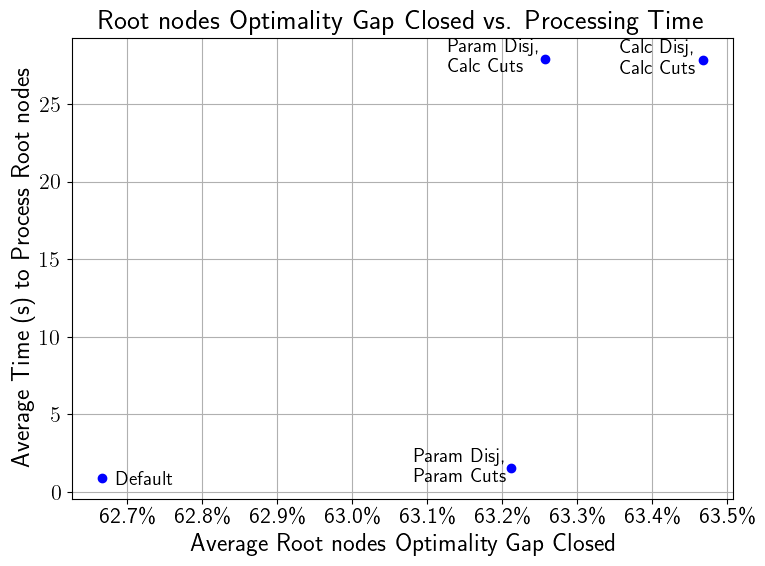

In [70]:
pareto_df = bound_df[[f for f in fields if "Root Cuts" in f or "rootDualBoundTime" in f]].mean().reset_index()
pareto_df.columns = ["key", "value"]

# Extract strength and time rows
strength_df = pareto_df[pareto_df['key'].str.contains("Root Cuts")].copy()
strength_df['category'] = strength_df['key'].str.extract(r'\((.*?)\)')
# strength_df["value"] = 100 * strength_df["value"]

time_df = pareto_df[pareto_df['key'].str.contains("rootDualBoundTime")].copy()
time_df['category'] = time_df['key'].str.extract(r'(None|Farkas|Old|New)')

# Merge data on category
merged_df = pd.merge(strength_df, time_df, on='category', suffixes=('_strength', '_time'))

# update column names
merged_df['category'] = merged_df['category'].replace(cat_map_new_lines)

# Create plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['value_strength'], merged_df['value_time'], color='blue', label='Data Points')
plt.xlabel("Average Root nodes Optimality Gap Closed")
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0, 1))
plt.ylabel("Average Time (s) to Process Root nodes")
plt.title("Root nodes Optimality Gap Closed vs. Processing Time")
plt.grid(True)

# Annotate points with categories
for _, row in merged_df.iterrows():
    offset = (10, -5) if row['category'] == "Default" else (-60, -10) if "Param" not in row["category"] else (-70, -10)
    plt.annotate(row['category'], (row['value_strength'], row['value_time']),
                 textcoords="offset points", xytext=offset, fontsize=14)

plt.tight_layout()

plt.savefig(os.path.join(
    out_fldr, f"strength_vs_time.png"
), dpi=1200)

# plt.show()

In [71]:
# order merged_df by strength
merged_df.sort_values("value_strength", ascending=True)[["key_strength", "value_strength", "value_time"]]

,key_strength,value_strength,value_time
0,Root Cuts (None),0.626665,0.901715
3,Root Cuts (Farkas),0.632121,1.532300
2,Root Cuts (Old),0.632571,27.948501
1,Root Cuts (New),0.634678,27.869697


## Check Termination Stats

In [72]:
# only check perturbed instances that solve to optimality and VPC didn't find optimal solution
mask = (df["Disjunction (New)"] < .9999) & (df["instanceIndex"] > 0) & (optimality_gap(df, "New") <= 1e-4) & \
    (optimality_gap(df, "None") <= 1e-4) & (optimality_gap(df, "Farkas") <= 1e-4) & \
       (df["terminationTime None"] > min_termination_time)
if remove_status_changes:
    mask = mask & (df["infeasibleToFeasibleTermsRatio Farkas"] == 0) & (df["feasibleToInfeasibleTermsRatio Farkas"] == 0)

gap_df = df.loc[mask]

In [73]:
gap_df.head()

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,zeroInfeasibleToFeasibleTerms New,feasibleToInfeasibleTermsRatio New,infeasibleTermsRatio Old,infeasibleToFeasibleTermsRatio Old,zeroInfeasibleToFeasibleTerms Old,feasibleToInfeasibleTermsRatio Old,infeasibleTermsRatio Farkas,infeasibleToFeasibleTermsRatio Farkas,zeroInfeasibleToFeasibleTerms Farkas,feasibleToInfeasibleTermsRatio Farkas
19,1,None,16,906793.399681,906793.399681,906793.399681,9.106540e+06,9.135598e+06,9.135926e+06,0.000002,...,True,0.0,0.736842,0.0,True,0.368421,0.736842,0.0,True,0.368421
23,1,None,4,2432.537572,2432.537572,2432.537572,2.569921e+03,2.691000e+03,2.691000e+03,0.000002,...,True,0.0,0.000000,0.0,True,0.000000,0.000000,0.0,True,0.000000
24,2,None,4,2455.531372,2455.531372,2455.531372,2.647265e+03,2.724000e+03,2.724000e+03,0.000003,...,True,0.0,0.000000,0.0,True,0.000000,0.000000,0.0,True,0.000000
25,3,None,4,2469.341086,2469.341086,2469.341086,2.599561e+03,2.672000e+03,2.672000e+03,0.000004,...,True,0.0,0.000000,0.0,True,0.000000,0.000000,0.0,True,0.000000
26,4,None,4,2522.739825,2522.739825,2522.739825,2.649593e+03,2.708000e+03,2.708000e+03,0.000002,...,True,0.0,0.000000,0.0,True,0.000000,0.000000,0.0,True,0.000000


In [79]:
def plot_distributions(histogram_df, feature, bins=100, xlim=(-2, 1), perturbation=None, exclude_perturbation=False, title_x=.5):
    """
    Generate a grid of cumulative distribution functions (CDFs) for a given feature,
    one for each combination of terms and degrees.

    :param histogram_df: DataFrame containing the data
    :param feature: The feature to plot (as relative improvement)
    :param bins: Number of bins in each histogram (only for 'pmf')
    :param xlim: Tuple for the x-axis limits
    :param perturbation: Specific perturbation to filter for
    :param exclude_perturbation: If True, excludes the perturbation instead of including it
    """

    # Unique values in 'degree' and 'terms'
    unique_degrees = histogram_df['degree'].sort_values(ascending=False).unique()
    unique_terms = histogram_df['terms'].sort_values().unique()

    # Create subplots for the grid
    fig, axes = plt.subplots(len(unique_degrees), len(unique_terms),
                             figsize=(4 * len(unique_terms), 4 * len(unique_degrees)))

    for i, degree in enumerate(unique_degrees):
        for j, terms in enumerate(unique_terms):
            ax = axes[i, j] if len(unique_degrees) > 1 and len(unique_terms) > 1 else axes

            # Filter the DataFrame based on 'degree' and 'terms'
            subset_df = histogram_df[(histogram_df['degree'] == degree) & (histogram_df['terms'] == terms)]

            # Filter or exclude specific perturbation type
            if perturbation is not None:
                subset_df = subset_df[subset_df["perturbation"] == perturbation] if not exclude_perturbation \
                    else subset_df[subset_df["perturbation"] != perturbation]

            # Compute relative improvements
            relative_improvements = {
                "Farkas": -(subset_df[f"{feature} None"] - subset_df[f"{feature} Farkas"]) / subset_df[f"{feature} None"],
                "New": -(subset_df[f"{feature} None"] - subset_df[f"{feature} New"]) / subset_df[f"{feature} None"],
                "Old": -(subset_df[f"{feature} None"] - subset_df[f"{feature} Old"]) / subset_df[f"{feature} None"]
            }

            # Compute CDFs
            x = np.linspace(xlim[0], xlim[1], bins)
            y_farkas = [(relative_improvements["Farkas"] <= val).sum() / len(relative_improvements["Farkas"]) for val in x]
            y_new = [(relative_improvements["New"] <= val).sum() / len(relative_improvements["New"]) for val in x]
            y_old = [(relative_improvements["Old"] <= val).sum() / len(relative_improvements["Old"]) for val in x]

            ax.plot(x, y_farkas, label=cat_map["Farkas"], color="blue")
            ax.plot(x, y_new, label=cat_map["New"], color="green")
            ax.plot(x, y_old, label=cat_map["Old"], color="orange")

            # Highlight the region where Farkas is better than both New and Old
            fill_region = [y_farkas[k] > max(y_new[k], y_old[k]) for k in range(len(x))]
            ax.fill_between(x, np.maximum(y_new, y_old), y_farkas, where=fill_region,
                            facecolor='yellow', alpha=0.3,
                            label=f'Improvement from\n{cat_map["Farkas"]}')
        
            # Set plot limits and labels
            ax.set_xlim(xlim)
            ax.set_ylim(0, 1)
            ax.set_title(f"{degree} Degree{'s' if degree > 1 else ''}, {terms} Terms")
            if j == 0:
                ax.set_ylabel("Probability")
            if i == len(unique_degrees) - 1:
                ax.set_xlabel("Relative Change")

    # Add a common legend at the bottom
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(title_x, -0.05), ncol=5)

    # Adjust layout and add a title
    fig.suptitle(f"CDF of Relative Change in Solve {label[feature]}", x=title_x)
    plt.tight_layout()
    
    # Save the figure with tight layout
    plt.savefig(os.path.join(out_fldr, f"cdf_{feature}.png"), dpi=1200, bbox_inches='tight')

    # Show the plot
    plt.show()

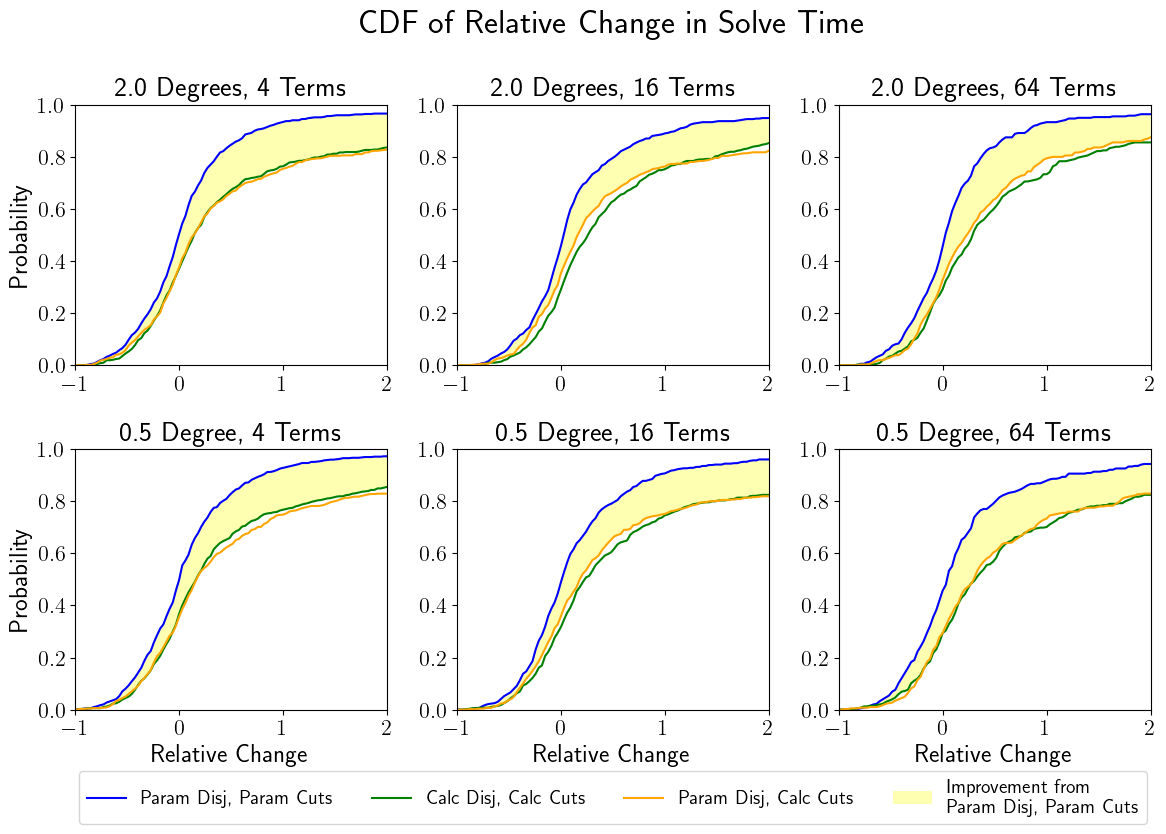

In [80]:
plot_distributions(gap_df, "terminationTime", xlim=(-1, 2), title_x=.525)

In [81]:
def plot_distributions_by_parameter(histogram_df, feature, plot_by='terms', bins=100, xlim=(-1, 2), perturbation=None, exclude_perturbation=False, title_x=.5):
    """
    Generate a grid of histograms or cumulative distribution functions (CDFs) for a given feature,
    one for each combination of terms and degrees, or group by a specific feature.

    :param histogram_df: DataFrame containing the data
    :param feature: The feature to plot (as relative improvement)
    :param kind: 'pmf' for probability mass function, 'cdf' for cumulative distribution functions
    :param bins: Number of bins in each histogram (only for 'pmf')
    :param xlim: Tuple for the x-axis limits
    :param perturbation: Specific perturbation to filter for
    :param exclude_perturbation: If True, excludes the perturbation instead of including it
    :param plot_by: 'degree' or 'terms' to determine the grouping variable for the plots
    """

    plt.rc('text', usetex=True)  # Use LaTeX fonts

    # Unique values for plotting
    unique_by = histogram_df[plot_by].sort_values().unique()
    unique_subplots = histogram_df['terms'].sort_values().unique() if plot_by == 'degree' else histogram_df['degree'].sort_values().unique()

    # Create subplots for the grid
    fig, axes = plt.subplots(1, len(unique_subplots), figsize=(5 * len(unique_subplots), 5), squeeze=False)

    for idx, subplot_val in enumerate(unique_subplots):
        ax = axes[0, idx]

        # Filter DataFrame for the subplot variable
        subplot_filter = (histogram_df['terms'] == subplot_val) if plot_by == 'degree' else (histogram_df['degree'] == subplot_val)
        subset_df = histogram_df[subplot_filter]

        # Filter or exclude specific perturbation type
        if perturbation is not None:
            subset_df = subset_df[subset_df["perturbation"] == perturbation] if not exclude_perturbation \
                else subset_df[subset_df["perturbation"] != perturbation]

        x = np.linspace(xlim[0], xlim[1], bins)
        for by_val in unique_by:
            by_filter = (subset_df[plot_by] == by_val)
            relative_improvement = (
                (subset_df.loc[by_filter, f"{feature} Farkas"] - subset_df.loc[by_filter, f"{feature} None"])
                / subset_df.loc[by_filter, f"{feature} None"]
            )
            y_cdf = [(relative_improvement <= val).sum() / len(relative_improvement) for val in x]
            ax.plot(x, y_cdf, label=f" {by_val} {plot_by.title() + ('s' if by_val > 1 and plot_by == 'degree' else '')}")

        # Set plot limits, labels, and title
        ax.set_xlim(xlim)
        ax.set_ylim(0, 1)
        ax.set_title(f"{subplot_val} {'Terms' if plot_by == 'degree' else 'Degree' + ('s' if subplot_val > 1 else '')}")
        if idx == 0:
            ax.set_ylabel("Probability")
        ax.set_xlabel("Relative Change")

    # Add a common legend at the bottom
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(title_x, -0.05), ncol=5)

    # Adjust layout and add a title4a
    fig.suptitle(f"CDF of Relative Change in Solve {label[feature]} for {cat_map['Farkas']}\nby {param_map['degree' if plot_by == 'terms' else 'terms']}", x=title_x)
    plt.tight_layout()
    
    # Save the figure with tight layout
    plt.savefig(os.path.join(out_fldr, f"cdf_{feature}_{'degree' if plot_by == 'terms' else 'terms'}.png"), dpi=1200, bbox_inches='tight')
    
    # Show the plot
    plt.show()

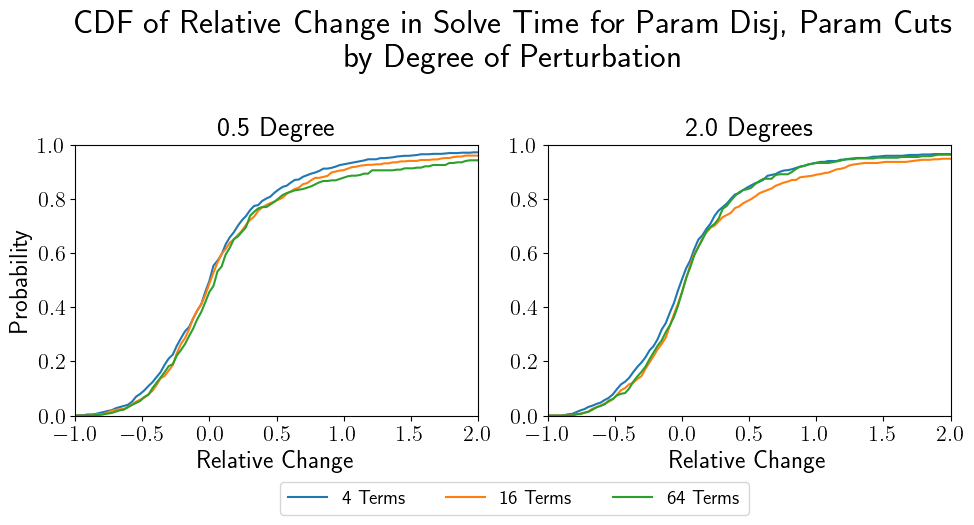

In [82]:
plot_distributions_by_parameter(gap_df, "terminationTime", plot_by='terms', title_x=.5315)

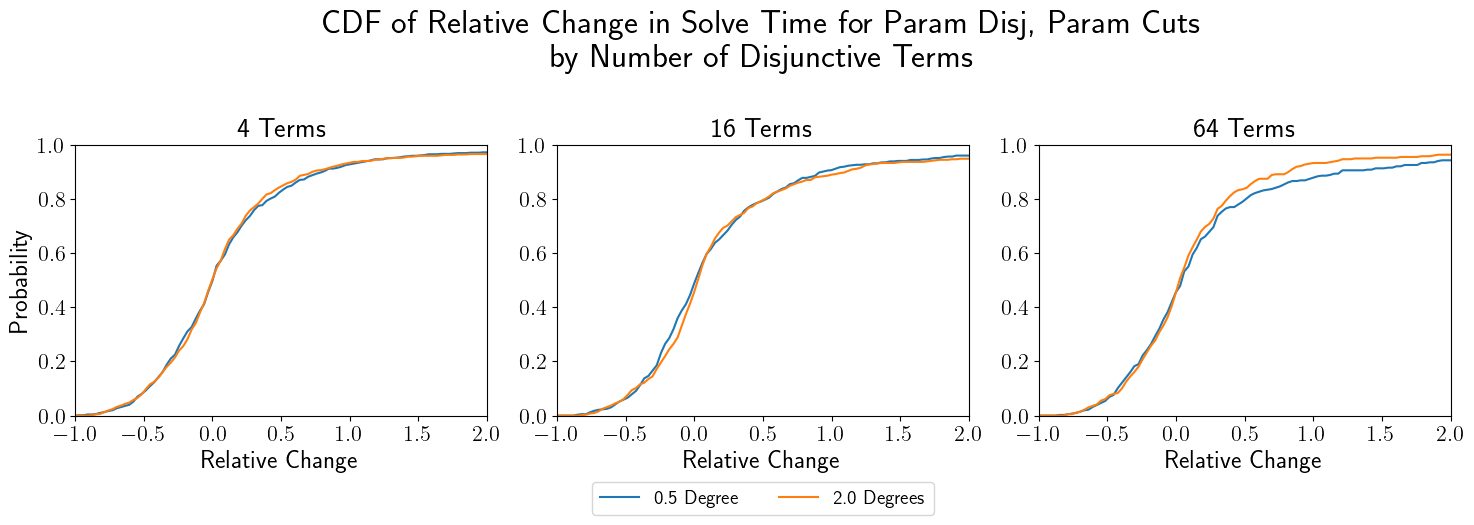

In [83]:
plot_distributions_by_parameter(gap_df, "terminationTime", plot_by='degree', title_x=.52)

In [105]:
def rename_cols(cols, feature):
    new_cols = []
    for col in cols:
        if f"{feature}Win" in col:
            col = col.replace(f"{feature}Win", f"{label[feature]} Win % ")
        elif "instanceIndex" in col:
            col = col.replace("instanceIndex", "Test Instances")
        elif "instance" in col:
            col = col.replace("instance", "Base Instances")
        new_cols.append(col)
    return new_cols

In [112]:
# get the win percentages for each feature on average and broken down by grouping type
features = ["nodes", "terminationTime", "terminationTimeSansVpc"]

wins = {}

for feature in features:
    
    # define aggregating operations
    aggregations = {f"{feature}WinFarkas": "mean", f"{feature}WinNone": "mean"}
    if feature == features[-1]:
        aggregations = aggregations | {"instance": "nunique", "instanceIndex": "count"}
    
    # find the average wins for the feature grouped by degree and terms
    feature_wins = gap_df[gap_df["perturbation"] != "bound"].groupby(["degree", "terms"]).agg(aggregations)
    
    # clean up formatting
    feature_wins.columns = rename_cols(feature_wins.columns, feature)
    win_cols = [c for c in feature_wins.columns if "Win" in c]
    feature_wins[win_cols] = feature_wins[win_cols].applymap(lambda x: round(x * 100, 2))
    instance_cols = [c for c in feature_wins.columns if "instance" in c]
    feature_wins[instance_cols] = feature_wins[instance_cols].applymap(lambda x: int(x))
    
    # save the df
    wins[feature] = feature_wins
    
# bring them all together now
all_wins = pd.concat(wins.values(), axis=1)
all_wins.reset_index().to_csv(os.path.join(out_fldr, f"branch_and_bound_wins.csv"), index=False, mode="w")
all_wins

Nodes Processed Win % Farkas  Nodes Processed Win % None  \
degree terms                                                             
0.5    4                             36.30                       34.15   
       16                            35.60                       34.88   
       64                            37.28                       32.59   
2.0    4                             34.47                       36.98   
       16                            34.43                       35.31   
       64                            35.33                       35.03   

              Time Win % Farkas  Time Win % None  \
degree terms                                       
0.5    4                  37.73            38.31   
       16                 38.46            39.00   
       64                 35.06            41.98   
2.0    4                  37.52            35.19   
       16                 31.80            37.72   
       64                 31.74            39.82   

              Time (Minus VPC Generation) Win % Farkas  \
degree terms                                             
0.5    4                                         38.16   
       16                                        40.25   
       64                                        37.78   
2.0    4                                         38.06   
       16                                        35.31   
       64                                        33.83   

              Time (Minus VPC Generation) Win % None  Base Instances  \
degree terms                                                           
0.5    4                                       37.88             100   
       16                                      38.10              96   
       64                                      38.27              74   
2.0    4                                       34.47             100   
       16                                      35.31              90   
       64                                      34.43              74   

              Test Instances  
degree terms                  
0.5    4                 697  
       16                559  
       64                405  
2.0    4                 557  
       16                456  
       64                334

In [113]:
def aggregate_wins(gap_df, feature, grouping):

    def custom_key(col):
        # bump improvement columns second to win percentage columns
        offset = int("Improvement %" in col)
        # check groupings
        if 'matrix' in col or 'short' in col:
            return (2 + offset, col)
        elif 'objective' in col or 'medium' in col:
            return (4 + offset, col)
        elif 'rhs' in col or 'long' in col:
            return (6 + offset, col)    
        return (offset, col)
    
    # find the average wins for the feature grouped by degree, terms and grouping type
    win_aggregations = {f"{feature}WinFarkas": "mean", f"{feature}WinNone": "mean"}
    feature_wins = gap_df[gap_df["perturbation"] != "bound"].groupby(["degree", "terms", grouping]).agg(win_aggregations).reset_index().pivot(
        index=['degree', 'terms'], columns=grouping, values=[f"{feature}WinFarkas", f"{feature}WinNone"]
    )
    feature_wins.columns = rename_cols([' '.join(col).strip() for col in feature_wins.columns.values], feature)
    feature_wins = feature_wins[sorted(feature_wins.columns, key=custom_key)]
    feature_wins = feature_wins.applymap(lambda x: round((1 - x) * 100, 2))
    
    # get the counts for the feature grouped by degree, terms and grouping type
    count_aggregations = {"instance": "nunique", "instanceIndex": "count"}
    feature_counts = gap_df[gap_df["perturbation"] != "bound"].groupby(["degree", "terms", grouping]).agg(count_aggregations).reset_index().pivot(
        index=['degree', 'terms'], columns=grouping, values=["instance", "instanceIndex"]
    )
    feature_counts.columns = rename_cols([' '.join(col).strip() for col in feature_counts.columns.values], feature)
    feature_counts = feature_counts[sorted(feature_counts.columns, key=custom_key)]
    feature_counts = feature_counts.applymap(lambda x: int(x))
    
    # save wins, base instance counts, and test instance counts to csv
    feature_wins.reset_index().to_csv(os.path.join(out_fldr, f"branch_and_bound_wins_{feature}_{grouping}.csv"), index=False, mode="w")
    feature_counts.reset_index().to_csv(os.path.join(out_fldr, f"branch_and_bound_counts_{grouping}.csv"), index=False, mode="w")
    
    return feature_wins, feature_counts

In [114]:
wins, counts = aggregate_wins(gap_df, "terminationTimeSansVpc", "bracket")
wins

Time (Minus VPC Generation) Win % Farkas short  \
degree terms                                                   
0.5    4                                               61.75   
       16                                              63.38   
       64                                              61.59   
2.0    4                                               63.59   
       16                                              65.43   
       64                                              63.79   

              Time (Minus VPC Generation) Win % None short  \
degree terms                                                 
0.5    4                                             62.46   
       16                                            62.91   
       64                                            62.91   
2.0    4                                             60.68   
       16                                            57.41   
       64                                            63.79   

              Time (Minus VPC Generation) Win % Farkas medium  \
degree terms                                                    
0.5    4                                                62.64   
       16                                               54.94   
       64                                               60.61   
2.0    4                                                60.77   
       16                                               63.81   
       64                                               67.30   

              Time (Minus VPC Generation) Win % None medium  \
degree terms                                                  
0.5    4                                              60.81   
       16                                             61.37   
       64                                             64.24   
2.0    4                                              67.69   
       16                                             68.10   
       64                                             62.89   

              Time (Minus VPC Generation) Win % Farkas long  \
degree terms                                                  
0.5    4                                              60.43   
       16                                             62.83   
       64                                             66.29   
2.0    4                                              61.54   
       16                                             65.48   
       64                                             67.80   

              Time (Minus VPC Generation) Win % None long  
degree terms                                               
0.5    4                                            64.03  
       16                                           61.06  
       64                                           55.06  
2.0    4                                            70.33  
       16                                           70.24  
       64                                           76.27

In [115]:
wins, counts = aggregate_wins(gap_df, "terminationTimeSansVpc", "perturbation")
wins

Time (Minus VPC Generation) Win % Farkas matrix  \
degree terms                                                    
0.5    4                                                58.55   
       16                                               61.54   
       64                                               59.09   
2.0    4                                                68.07   
       16                                               65.59   
       64                                               57.14   

              Time (Minus VPC Generation) Win % None matrix  \
degree terms                                                  
0.5    4                                              64.77   
       16                                             63.64   
       64                                             61.82   
2.0    4                                              65.55   
       16                                             67.74   
       64                                             74.60   

              Time (Minus VPC Generation) Win % Farkas objective  \
degree terms                                                       
0.5    4                                                  63.24    
       16                                                 60.24    
       64                                                 64.52    
2.0    4                                                  61.26    
       16                                                 63.49    
       64                                                 66.52    

              Time (Minus VPC Generation) Win % None objective  \
degree terms                                                     
0.5    4                                                 60.05   
       16                                                60.55   
       64                                                61.75   
2.0    4                                                 64.29   
       16                                                64.47   
       64                                                63.39   

              Time (Minus VPC Generation) Win % Farkas rhs  \
degree terms                                                 
0.5    4                                             62.50   
       16                                            55.06   
       64                                            60.26   
2.0    4                                             55.41   
       16                                            69.49   
       64                                            76.60   

              Time (Minus VPC Generation) Win % None rhs  
degree terms                                              
0.5    4                                           65.62  
       16                                          64.04  
       64                                          61.54  
2.0    4                                           71.62  
       16                                          61.02  
       64                                          63.83